In [1]:
# general import
import os
import pickle
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import time, datetime
import copy

# torch
import torch
import torch.nn as nn
import torch.optim as optim

# my own
from tasks import get_data
from myutils import *
from topology import gen_lattice, compute_dist

# increase cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

dtype = torch.float
device = torch.device("cpu")

# SOME USEFUL DEFINITIONS
relu = lambda x : (x > 0) * x
def pr(h, b):
    if b > 1e2:
        return 1. * (h > 0)
    else:
        return np.exp(b * h) / (2 * np.cosh(b * h))

In [156]:
# SET MAIN PARAMS

pars = Pars()

## random task name
#pars.dataset = "RANDOM"
# pars.dataset = "RANDOM-Y"
pars.dataset = "NLGP"
# pars.dataset = "RANDOM-FF-Teacher"
# pars.dataset = "RANDOM-FF-Teacher-Y"
# pars.dataset = "RANDOM-RNN-Teacher"
# pars.dataset = "RANDOM-RNN-Teacher-X"
# pars.dataset = "RANDOM-RNN-Teacher-Y"

## dataset name
# pars.dataset = "MNIST1D"
# pars.dataset = "MNIST"
# pars.dataset = "MNIST10"
# pars.dataset = "FashionMNIST"
# pars.dataset = "CIFAR10"
# pars.dataset = "CIFAR100"

## random dataset options
pars.alpha_train = 0.3 # fraction of training patterns wrt N in a random task
pars.alpha_test = 0 # fraction of test patterns wrt N in a random task
pars.span_h = False # generate all h in range (only makes sense for N=2 or N=3)
pars.exp_input = False # exponentially distributed input (default is gaussian)
pars.rho = 0. # input covariance

## teacher-student FF options
pars_teacher = {}
# pars_teacher["K"] = 1 # number of hidden units in the random teacher
# pars_teacher["nonlinearity"] = "linear" # activation function : sigmoid | tanh | erf | relu | linear
# pars_teacher["g_bias_in"] = 0. # gain for biases initialization
# pars_teacher["soft_w"] = True # constant output weights
# pars_teacher["num_out"] = 1 # number of output units 
# pars_teacher["g"] = 1. # gain of ff weights
# pars_teacher["J"] = None # optionally make your own kind of teacher
# pars.pars_teacher = pars_teacher

# ## teacher-student RNN options
# pars_teacher = {}
# pars_teacher["K"] = 40 # number of hidden units in the random teacher
# pars_teacher["nonlinearity"] = "relu" # activation function : sigmoid | tanh | erf | relu | linear
# pars_teacher["discrete_time"] = False # type of temporal dynamics
# pars_teacher["dt"] = 0.1 # time discretization
# pars_teacher["eye_in"] = True # identity input weights
# pars_teacher["g_bias_in"] = 0. # gain for biases initialization
# pars_teacher["soft_w"] = False # constant output weights
# pars_teacher["num_out"] = 1 # number of output units 
# pars_teacher["g"] = 0.8 # gain of recurrent weights
# pars_teacher["J"] = None # optionally make your own kind of teacher
# pars.pars_teacher = pars_teacher

## NLGP specific options
pars.torus = True # whether to use a torus topology
pars.g_nonlin = 1e-10 # gain parameter for nonlinearity
pars.xis = [16] # lenght-scales of mixtures

## spatial options
pars.dim = 1 # input dimension
pars.lN = 500 # linear input size
pars.normalize = False # normalize inputs (some dataset are already normalized)

## misc options
pars.seed_data = 4
pars.data_dir = f'data'
pars.save_dir = f'results_notebook'

# # TO DIRECTLY DOWNLOAD MNIST1D USE THE FOLLOWING:
# import requests
# url = 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'
# r = requests.get(url, allow_redirects=True)
# save_dir_dataset = save_dir + "/" + dataset
# open(f'{data_dir}/mnist1d_data.pkl', 'wb').write(r.content)

In [157]:
# GET DATASET
makedir(pars.data_dir)
data_and_properties = get_data(pars, dtype=dtype, device=device)
train_dataset, test_dataset, teacher_weights, x_teacher = data_and_properties
print(f"{pars.dim} dimensional inputs of size {pars.lN}^{pars.dim} = {pars.N}")
print(f"num train: {pars.num_train}, num test: {pars.num_test}, num label: {pars.num_label}")

1 dimensional inputs of size 500^1 = 500
num train: 150, num test: 0, num label: 1


In [158]:
# #Using dataset: NLGP

# X_train, y_train = extract_tensors(train_dataset)
# print(pars.N)
# print(X_train)
# print(y_train)
# print(X_train[:,1])

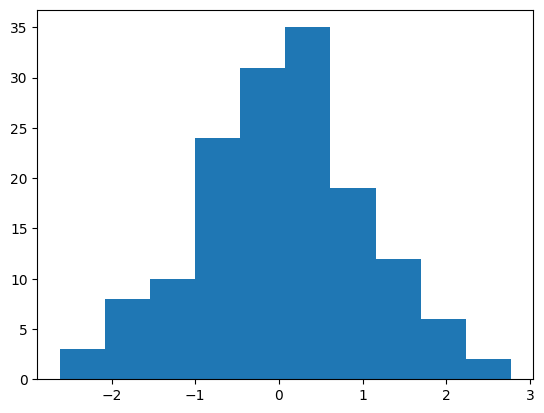

In [160]:
X_to_plot_train, y_to_plot_train = extract_tensors(train_dataset)

plt.hist(X_to_plot_train[:,0].flatten().tolist())
#plt.plot(X_to_plot_train[1,:].flatten().tolist(),'-')
plt.show()

/home/joshy/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/joshy/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


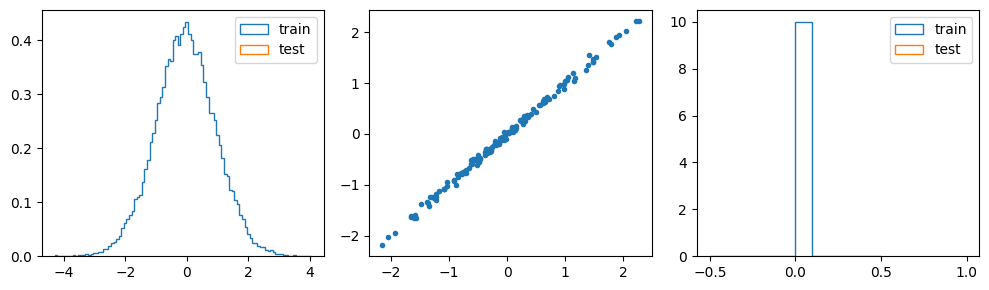

In [85]:
# WATCH RANDOM DATA DISTRIBUTION

if "RANDOM" in pars.dataset or "GP" in pars.dataset:
    plt.figure(figsize=(10,3))

    X_to_plot_train, y_to_plot_train = extract_tensors(train_dataset)
    if pars.num_test is not None:
        X_to_plot_test, y_to_plot_test = extract_tensors(test_dataset)

    # Plot distribution of all obtained datapoints (both train and test)
    plt.subplot(131)
    plt.hist(X_to_plot_train.flatten().tolist(), bins=100, density=True, histtype="step", label="train");
    if pars.num_test is not None:
        plt.hist(X_to_plot_test.flatten().tolist(), bins=50, density=True, histtype="step", label="test");
    plt.legend();

    # First data-point vs 2nd data-point, to see correlation between them (only training dataset)
    plt.subplot(132)
    plt.plot(X_to_plot_train[:,0], X_to_plot_train[:,1], '.');
#     plt.plot(X_to_plot_train[:,0], X_to_plot_train[:,2], '.');

    # Distribution of all values obtained for y (both train and test)
    plt.subplot(133)
    plt.hist(y_to_plot_train.flatten().tolist(), density=True, histtype="step", label="train");
    if pars.num_test is not None:
        plt.hist(y_to_plot_test.flatten().tolist(), density=True, histtype="step", label="test");
    plt.legend();

    plt.tight_layout()

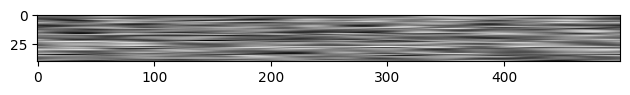

/home/joshy/Tareas/ICTP/Tesis/myutils.py:383: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(X_to_plot_test.cpu()[y_to_plot_test==y][:upto_dim1], cmap=cmap)


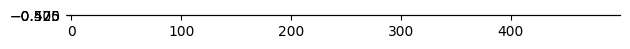

In [86]:
# WATCH DATASET
watch_dataset(train_dataset, test_dataset, pars)

In [4]:
#Using dataset: RANDOM

X_train, y_train = extract_tensors(train_dataset)
print(pars.N)
print(X_train)
print(y_train)
print(X_train.flatten())

5
tensor([[ 1.6243, -0.6118, -0.5282, -1.0730,  0.8654],
        [-2.3015,  1.7448, -0.7612,  0.3190, -0.2494],
        [ 1.4621, -2.0601, -0.3224, -0.3841,  1.1338],
        [-1.0999, -0.1724, -0.8779,  0.0422,  0.5828],
        [-1.1006,  1.1447,  0.9016,  0.5025,  0.9009]])
tensor([1., 1., 0., 1., 0.])
tensor([ 1.6243, -0.6118, -0.5282, -1.0730,  0.8654, -2.3015,  1.7448, -0.7612,
         0.3190, -0.2494,  1.4621, -2.0601, -0.3224, -0.3841,  1.1338, -1.0999,
        -0.1724, -0.8779,  0.0422,  0.5828, -1.1006,  1.1447,  0.9016,  0.5025,
         0.9009])
